In [126]:
from datetime import datetime as dt
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

LOG_DIR = "/home/engineer/fltk-testbed/logging"
EXP_NAME = "exp_8"
CREATE_LOG = f"{LOG_DIR}/{EXP_NAME}/create.log"
START_LOG = f"{LOG_DIR}/{EXP_NAME}/start.log"
STOP_LOG = f"{LOG_DIR}/{EXP_NAME}/stop.log"

In [127]:
logs = [CREATE_LOG, START_LOG, STOP_LOG]
containers = defaultdict(dict)

for log in logs:
    with open(log, "r") as f:
        while line := f.readline():
            split = line.rstrip().split()
            key = Path(log).stem
            value = dt.strptime(f"{split[0]} {split[1]}", "%m-%d-%Y %H:%M:%S")
            containers[split[2]] |= {key: value}

In [128]:
for c in containers:
    container = containers[c]
    assert container["create"] < container["start"], f"{c} created after started"
    assert container["start"] < container["stop"], f"{c} started after stopped"
    container["queue"] = (container["start"] - container["create"]).total_seconds()
    container["service"] = (container["stop"] - container["start"]).total_seconds()
    container["response"] = (container["stop"] - container["create"]).total_seconds()

In [129]:
queues = []
services = []
responses = []

for c in containers:
    container = containers[c]
    queues.append(container["queue"] / 60)
    services.append(container["service"] / 60)
    responses.append(container["response"] / 60)


In [130]:
def plot(data, containers, label):
    fig, ax = plt.subplots(figsize=(15, 5), tight_layout=True)
    ax.axhline(
        np.mean(data),
        xmin=0.05,
        xmax=0.95,
        linestyle="--",
        color="r",
        alpha=0.5,
        label="Mean",
    )
    x = range(1, len(containers) + 1)
    ax.plot(x, data, "-o", label=label)
    ax.legend()
    ax.set_xticks(x)
    ax.set_xlabel("Job")
    ax.set_ylabel("Time (min)")
    ax.set_title(f"{label} for Jobs")
    mean = np.mean(data)
    std = np.std(data)
    fig.text(
        0.5,
        -0.07,
        f"mean: {mean.round(2)}\nstd: {std.round(2)}",
        ha="center",
        bbox=dict(facecolor="none", edgecolor="lightgray", boxstyle="round"),
    )
    fig.autofmt_xdate()

    return mean, std

Mean Queue Time: 108.90811965811965
Std Queue Time: 80.02271382250446
Mean Service Time: 6.411965811965812
Std Service Time: 0.12165459007788718
Mean Response Time: 115.32008547008547
Std Response Time: 80.08912193737204


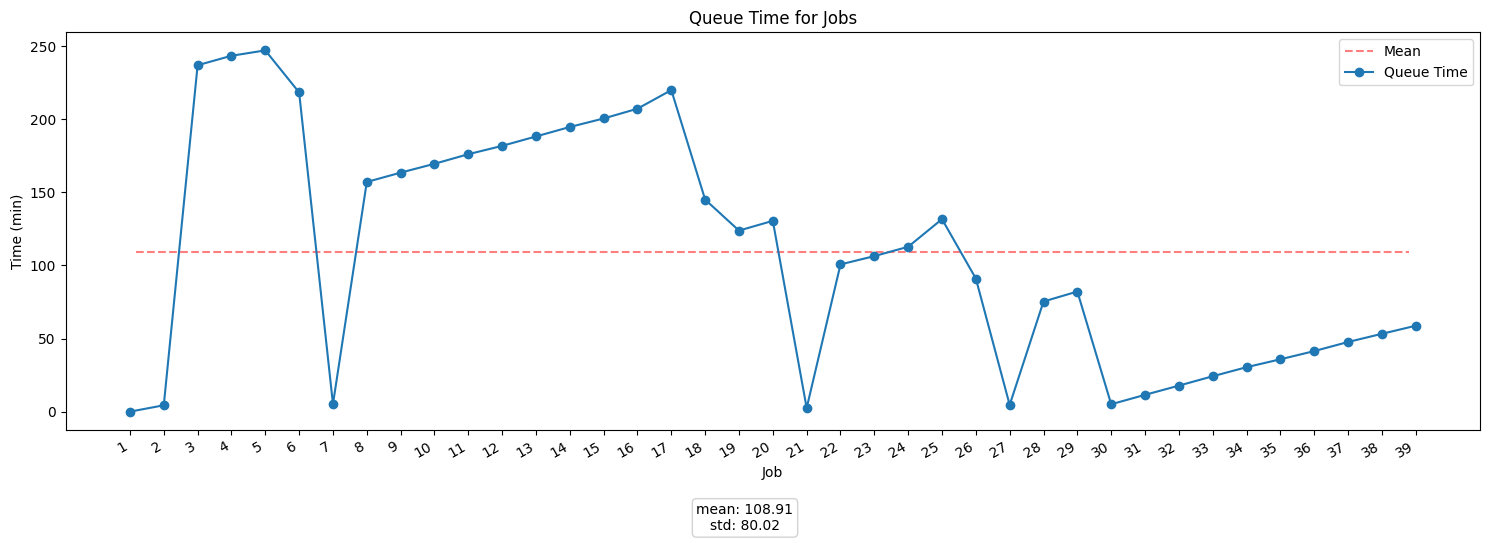

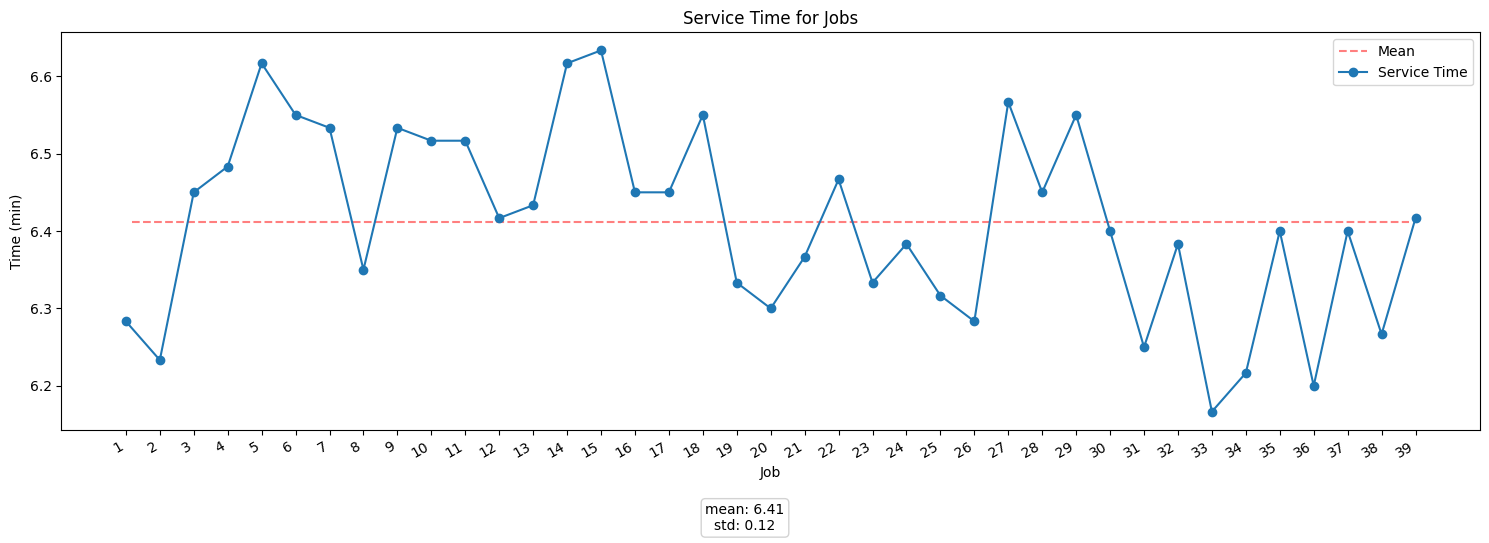

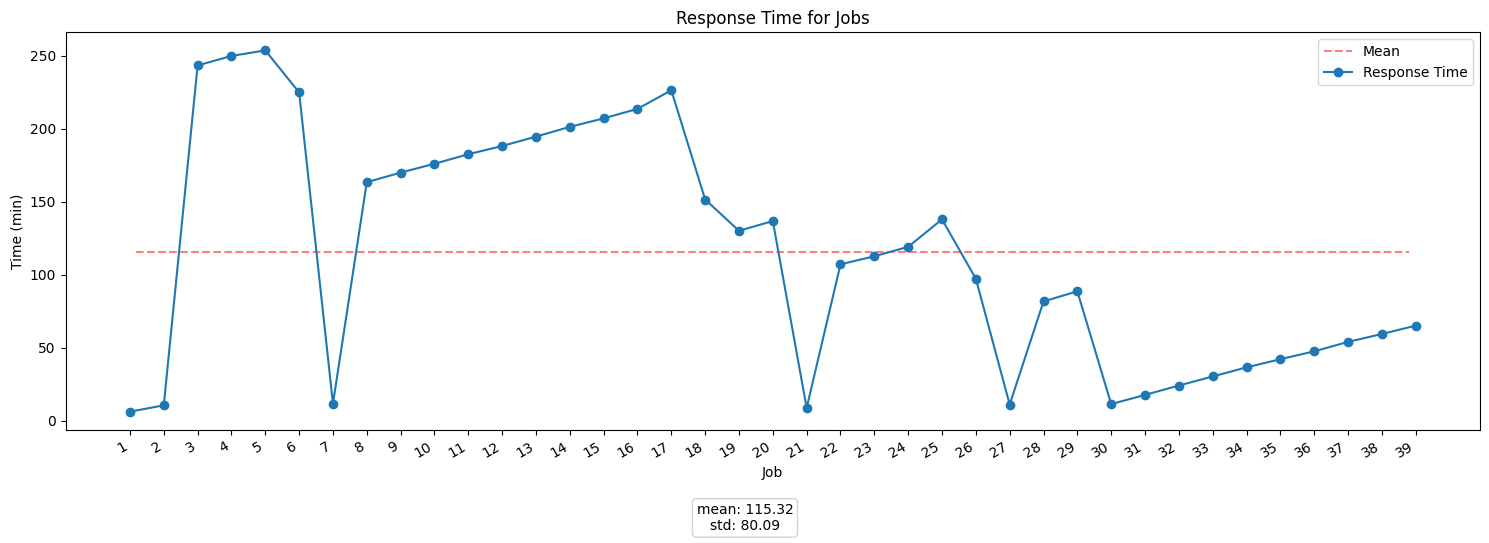

In [131]:
mean_queue, std_queue = plot(queues, containers, "Queue Time")
mean_service, std_service = plot(services, containers, "Service Time")
mean_response, std_response = plot(responses, containers, "Response Time")

print(f"Mean Queue Time: {mean_queue}")
print(f"Std Queue Time: {std_queue}")
print(f"Mean Service Time: {mean_service}")
print(f"Std Service Time: {std_service}")
print(f"Mean Response Time: {mean_response}")
print(f"Std Response Time: {std_response}")

In [132]:
# Compare all queues with Mean Response Time
LAMBDA = 1
MU = 1 / mean_service
RHO = LAMBDA / MU
print(MU)

# M/M/1
mm1_mean_response = 1 / (MU - LAMBDA)
# print((RHO / (1-RHO))*(1/MU)+1/MU)

# M/D/1
md1_mean_response = (RHO + (1 / 2) * (RHO**2 / (1 - RHO))) / LAMBDA

# M/G/1
mg1_mean_response = mean_service + (std_service**2 / ((2 * mean_service) * (1 - RHO)))

print(f"M/M/1 Mean Response Time: {mm1_mean_response}")
print(f"M/D/1 Mean Response Time: {md1_mean_response}")
print(f"M/G/1 Mean Response Time: {mg1_mean_response}")

0.1559584110903759
M/M/1 Mean Response Time: -1.1847757422615288
M/D/1 Mean Response Time: 2.6135950348521413
M/G/1 Mean Response Time: 6.411752566030805
